# Разведочный анализ данных: предсказание Profit

Данные: блоковая модель рудника (mining_block_model.csv).  
Цель: разведочный анализ и предсказание целевого признака **Profit (USD)** с помощью **XGBoost**, **линейной регрессии** и **Random Forest** с сравнением результатов.

In [ ]:
# Дополнительные импорты для моделей и метрик
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline

# XGBoost (если не установлен: !pip install xgboost)
try:
    from xgboost import XGBRegressor
    print("XGBoost успешно импортирован")
except ImportError:
    print("XGBoost не установлен. Установите: pip install xgboost")

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', 20)
plt.rcParams['figure.figsize'] = (10, 5)
sns.set_style('whitegrid')

df = pd.read_csv('mining_block_model.csv')
print('Размер:', df.shape)
df.head(10)

Размер: (75000, 13)


,Block_ID,X,Y,Z,Rock_Type,Ore_Grade (%),Tonnage,Ore_Value (USD/tonne),Mining_Cost (USD),Processing_Cost (USD),Waste_Flag,Profit (USD),Target
0,B00001,102,186,6,Magnetite,51.93,2131,1.94,0.35,0.25,0,2861.86,1
1,B00002,435,448,82,Hematite,59.05,1550,1.80,0.24,0.22,0,2086.92,1
2,B00003,348,476,94,Magnetite,63.79,2414,2.23,0.38,0.18,0,4036.63,1
3,B00004,270,127,98,Hematite,64.98,1297,2.03,0.20,0.19,0,2128.07,1
4,B00005,106,111,92,Waste,0.00,1309,0.00,0.44,0.18,1,-820.74,0
5,B00006,71,492,46,Magnetite,64.42,1235,1.96,0.22,0.18,0,1919.64,1
6,B00007,188,293,32,Magnetite,52.46,2706,2.11,0.30,0.18,0,4432.75,1
7,B00008,20,421,21,Hematite,51.22,1708,1.75,0.27,0.15,0,2275.64,1
8,B00009,102,148,66,Magnetite,51.80,1725,1.67,0.32,0.14,0,2093.25,1
9,B00010,121,150,76,Waste,0.00,1865,0.00,0.38,0.20,1,-1095.50,0


## 1. Структура и типы данных

In [14]:
df.info()
print('\n--- Пропуски ---')
print(df.isnull().sum())
print('\n--- Дубликаты по Block_ID ---')
print(df['Block_ID'].duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Block_ID               75000 non-null  object 
 1   X                      75000 non-null  int64  
 2   Y                      75000 non-null  int64  
 3   Z                      75000 non-null  int64  
 4   Rock_Type              75000 non-null  object 
 5   Ore_Grade (%)          75000 non-null  float64
 6   Tonnage                75000 non-null  int64  
 7   Ore_Value (USD/tonne)  75000 non-null  float64
 8   Mining_Cost (USD)      75000 non-null  float64
 9   Processing_Cost (USD)  75000 non-null  float64
 10  Waste_Flag             75000 non-null  int64  
 11  Profit (USD)           75000 non-null  float64
 12  Target                 75000 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 7.4+ MB

--- Пропуски ---
Block_ID                 0
X   

## 2. Описательная статистика

In [15]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Block_ID,75000,75000,B75000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
X,75000.0,NaN,NaN,NaN,249.24268,144.613539,0.0,123.0,249.0,375.0,499.0
Y,75000.0,NaN,NaN,NaN,248.77324,143.852756,0.0,124.0,248.0,373.0,499.0
Z,75000.0,NaN,NaN,NaN,49.52536,28.858031,0.0,24.0,50.0,75.0,99.0
Rock_Type,75000,3,Hematite,29995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ore_Grade (%),75000.0,NaN,NaN,NaN,45.992171,23.343018,0.0,50.92,55.62,60.34,65.0
Tonnage,75000.0,NaN,NaN,NaN,2000.47508,577.028563,1000.0,1501.0,2003.0,2501.0,2999.0
Ore_Value (USD/tonne),75000.0,NaN,NaN,NaN,1.583005,0.810342,0.0,1.69,1.9,2.1,2.31
Mining_Cost (USD),75000.0,NaN,NaN,NaN,0.327176,0.076948,0.2,0.26,0.33,0.4,0.46
Processing_Cost (USD),75000.0,NaN,NaN,NaN,0.194088,0.038047,0.13,0.16,0.19,0.23,0.26


## 3. Целевая переменная Profit

Profit: mean = 2125.24, std = 1806.51, min = -2093.20, max = 5831.25
Медиана: 2496.045
Асимметрия (skew): -0.7251800461251265
Эксцесс (kurtosis): -0.47094036959886454


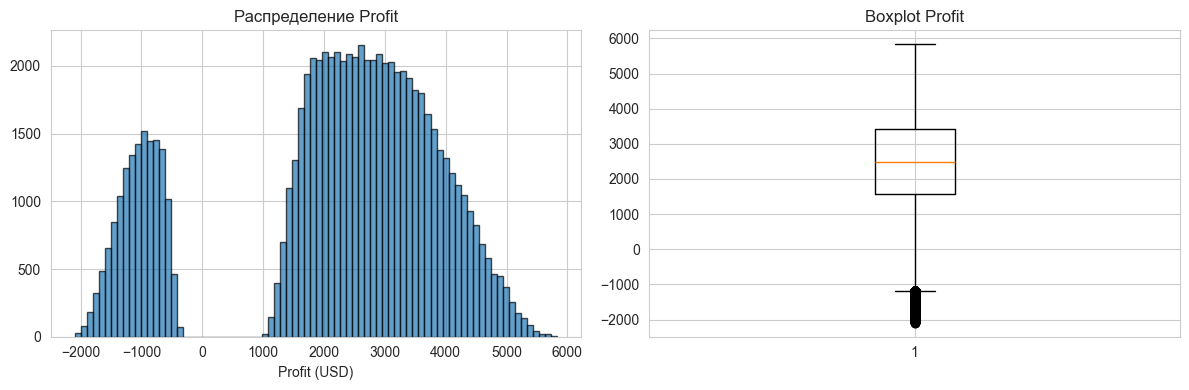

In [16]:
profit = df['Profit (USD)']
print('Profit: mean = {:.2f}, std = {:.2f}, min = {:.2f}, max = {:.2f}'.format(
    profit.mean(), profit.std(), profit.min(), profit.max()))
print('Медиана:', profit.median())
print('Асимметрия (skew):', profit.skew())
print('Эксцесс (kurtosis):', profit.kurtosis())
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(profit, bins=80, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение Profit')
axes[0].set_xlabel('Profit (USD)')
axes[1].boxplot(profit, vert=True)
axes[1].set_title('Boxplot Profit')
plt.tight_layout()
plt.show()

## 4. Корреляции с Profit (числовые признаки)

Корреляции с Profit (по модулю):
Ore_Value (USD/tonne)    0.8987
Waste_Flag              -0.8779
Ore_Grade (%)            0.8658
Tonnage                  0.3452
Mining_Cost (USD)       -0.0878
Processing_Cost (USD)   -0.0431
X                       -0.0050
Y                       -0.0021
Z                       -0.0007
dtype: float64


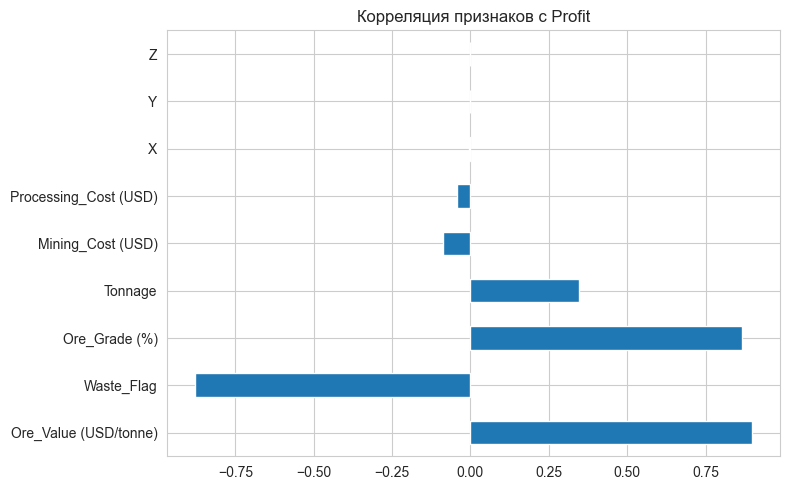

In [17]:
numeric = df.select_dtypes(include=[np.number]).drop(columns=['Profit (USD)', 'Target'], errors='ignore')
corr_with_profit = numeric.corrwith(df['Profit (USD)']).sort_values(key=abs, ascending=False)
print('Корреляции с Profit (по модулю):')
print(corr_with_profit.round(4))
corr_with_profit.plot(kind='barh', figsize=(8, 5), title='Корреляция признаков с Profit')
plt.tight_layout()
plt.show()

## 5. Матрица корреляций (мультиколлинеарность)

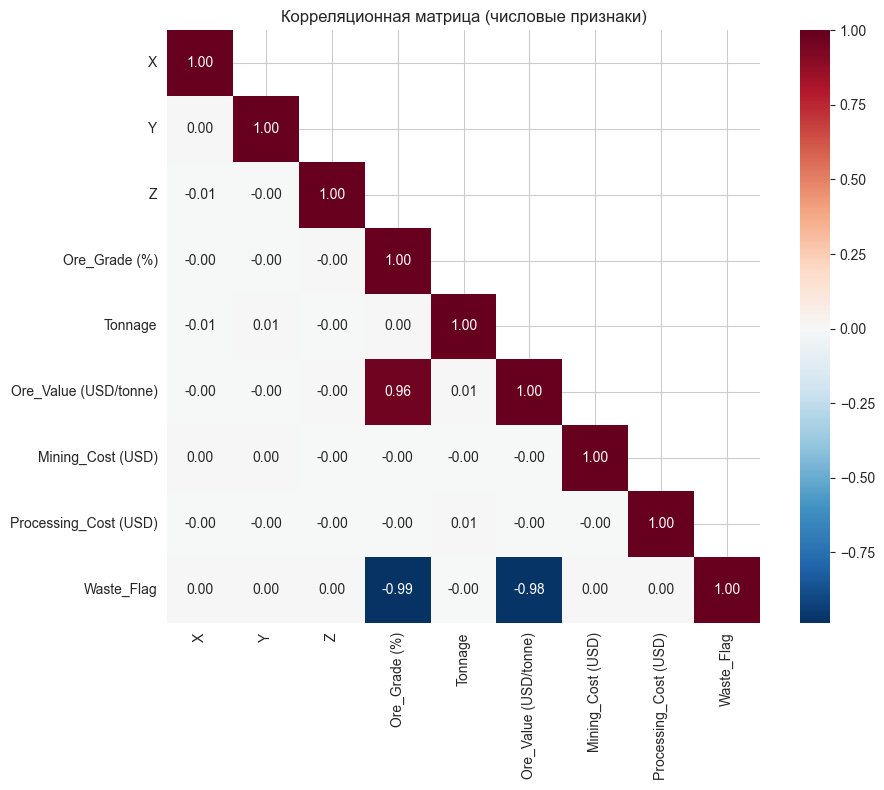

In [18]:
corr = numeric.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)  # верхний треугольник
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, square=True)
plt.title('Корреляционная матрица (числовые признаки)')
plt.tight_layout()
plt.show()

## 6. Связь ключевых предикторов с Profit (выборка для визуализации)

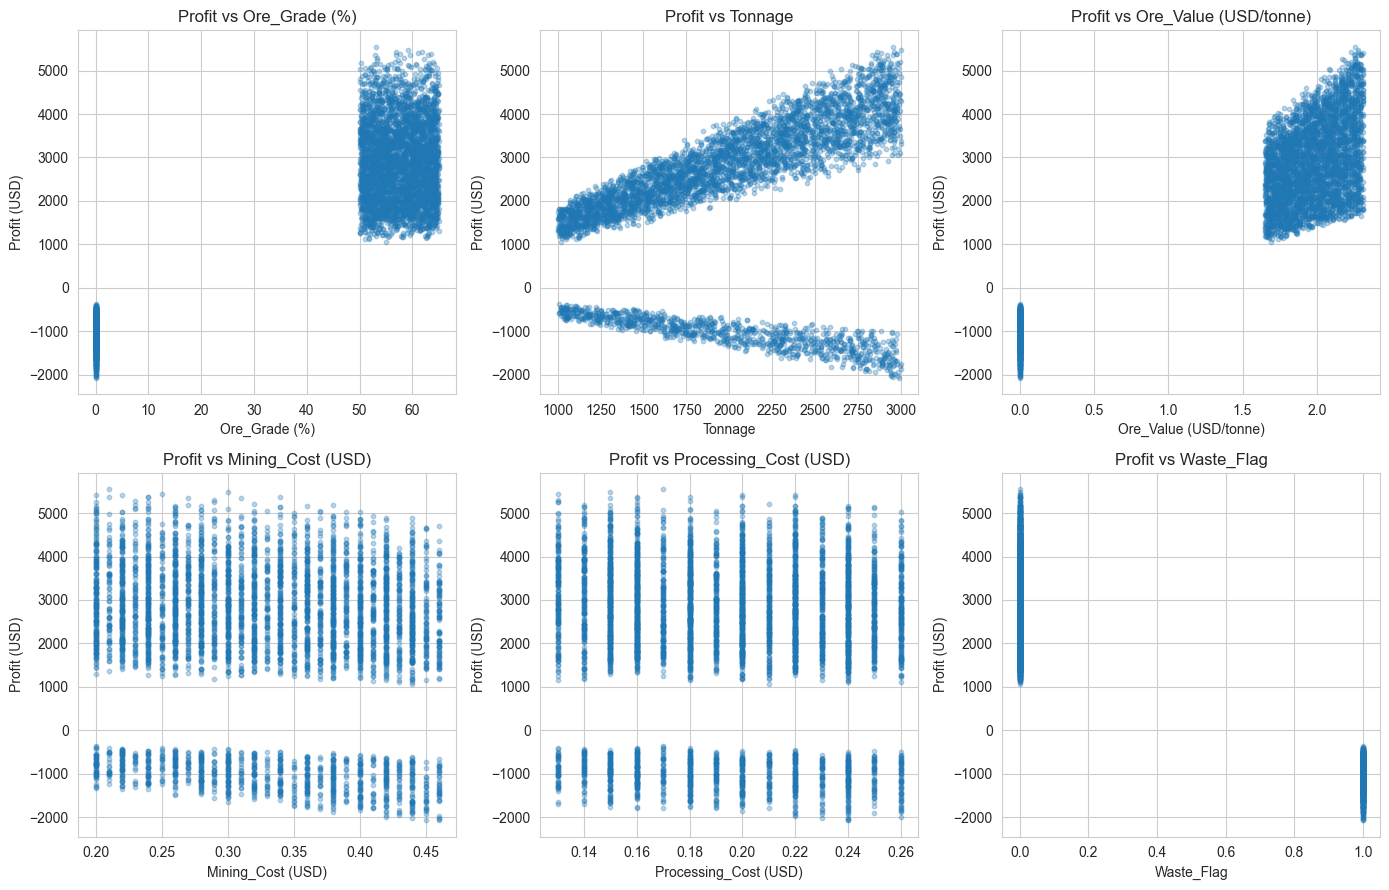

In [19]:
# Для скорости берём подвыборку при большом объёме
sample = df.sample(n=min(5000, len(df)), random_state=42) if len(df) > 5000 else df
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.ravel()
for i, col in enumerate(['Ore_Grade (%)', 'Tonnage', 'Ore_Value (USD/tonne)', 
                          'Mining_Cost (USD)', 'Processing_Cost (USD)', 'Waste_Flag']):
    if col in df.columns:
        axes[i].scatter(sample[col], sample['Profit (USD)'], alpha=0.3, s=10)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Profit (USD)')
        axes[i].set_title(f'Profit vs {col}')
plt.tight_layout()
plt.show()

## 7. Категориальный признак Rock_Type и Profit

## 8. Линейность и выбросы (остатки после простой регрессии)

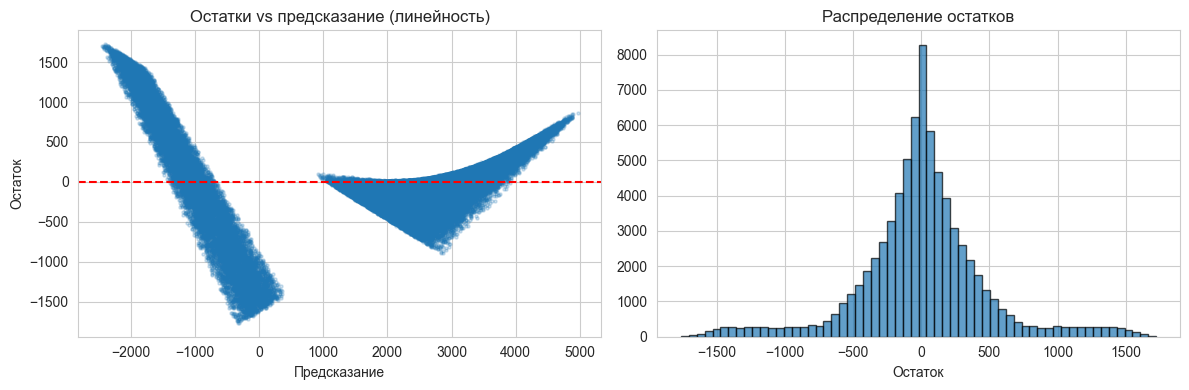

R² на всех данных: 0.9323359055237013


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Признаки для быстрой проверки (без категориальных)
feat_cols = ['X', 'Y', 'Z', 'Ore_Grade (%)', 'Tonnage', 'Ore_Value (USD/tonne)', 
             'Mining_Cost (USD)', 'Processing_Cost (USD)', 'Waste_Flag']
X = df[feat_cols].fillna(0)
y = df['Profit (USD)']

lm = LinearRegression()
lm.fit(X, y)
y_pred = lm.predict(X)
residuals = y - y_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(y_pred, residuals, alpha=0.2, s=5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Предсказание')
axes[0].set_ylabel('Остаток')
axes[0].set_title('Остатки vs предсказание (линейность)')
axes[1].hist(residuals, bins=60, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Остаток')
axes[1].set_title('Распределение остатков')
plt.tight_layout()
plt.show()
print('R² на всех данных:', lm.score(X, y))

## 9. VIF (фактор инфляции дисперсии) для мультиколлинеарности

In [21]:
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    feat_cols = ['X', 'Y', 'Z', 'Ore_Grade (%)', 'Tonnage', 'Ore_Value (USD/tonne)', 
                 'Mining_Cost (USD)', 'Processing_Cost (USD)', 'Waste_Flag']
    X_const = df[feat_cols].fillna(0)
    vif = pd.DataFrame()
    vif['Признак'] = feat_cols
    vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
    vif = vif.sort_values('VIF', ascending=False)
    print('VIF > 5–10 говорит о сильной мультиколлинеарности:')
    print(vif)
except ImportError:
    print('Установите statsmodels: pip install statsmodels')

VIF > 5–10 говорит о сильной мультиколлинеарности:
                 Признак        VIF
3          Ore_Grade (%)  84.109776
5  Ore_Value (USD/tonne)  74.351827
7  Processing_Cost (USD)  25.274141
6      Mining_Cost (USD)  18.247643
4                Tonnage  12.678106
8             Waste_Flag  12.031104
1                      Y   3.961291
0                      X   3.940540
2                      Z   3.915643


## 11. Подготовка данных и разбиение train/test

Формируем матрицу признаков (с кодированием Rock_Type) и целевую переменную, разбиваем на обучающую и тестовую выборки.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Числовые признаки (без Target и Profit)
num_cols = ['X', 'Y', 'Z', 'Ore_Grade (%)', 'Tonnage', 'Ore_Value (USD/tonne)', 
            'Mining_Cost (USD)', 'Processing_Cost (USD)', 'Waste_Flag']
cat_cols = ['Rock_Type']

X_num = df[num_cols].fillna(0)
X_cat = df[cat_cols]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
])
X_full = preprocessor.fit_transform(pd.concat([X_num, X_cat], axis=1))
y = df['Profit (USD)']

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
print('Train:', X_train.shape[0], 'Test:', X_test.shape[0])
print('Признаков после кодирования:', X_train.shape[1])

Train: 60000 Test: 15000
Признаков после кодирования: 11


## 12. Модель: линейная регрессия

Обучаем линейную регрессию на train и оцениваем метрики на test.

## 10. Выводы и рекомендации для линейной регрессии

## 13. Модель: Random Forest

Обучаем Random Forest и оцениваем те же метрики.

In [ ]:
# Обучение XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print('XGBoost (тест):')
print(f'  R²   = {r2_xgb:.4f}')
print(f'  MAE  = {mae_xgb:.2f} USD')
print(f'  RMSE = {rmse_xgb:.2f} USD')

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=5, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print('Random Forest (тест):')
print(f'  R²   = {r2_rf:.4f}')
print(f'  MAE  = {mae_rf:.2f} USD')
print(f'  RMSE = {rmse_rf:.2f} USD')

NameError: name 'r2_score' is not defined

In [ ]:
# Сравнение моделей
# Сначала нужно получить метрики для Linear Regression, если они еще не вычислены
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Обучение Linear Regression на тех же данных
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred_lm = lm.predict(X_test)

r2_lm = r2_score(y_test, y_pred_lm)
mae_lm = mean_absolute_error(y_test, y_pred_lm)
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_lm))

# Создаем таблицу сравнения
comparison = pd.DataFrame({
    'Модель': ['Линейная регрессия', 'Random Forest', 'XGBoost'],
    'R²': [r2_lm, r2_rf, r2_xgb],
    'MAE': [mae_lm, mae_rf, mae_xgb],
    'RMSE': [rmse_lm, rmse_rf, rmse_xgb]
})

print('=== Сравнение моделей ===')
print(comparison.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['R²', 'MAE', 'RMSE']
for i, metric in enumerate(metrics):
    axes[i].bar(comparison['Модель'], comparison[metric])
    axes[i].set_title(f'{metric}')
    axes[i].set_ylabel('Значение')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Визуализация предсказаний vs реальные значения
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

predictions = {
    'Линейная регрессия': y_pred_lm,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

for i, (name, y_pred) in enumerate(predictions.items()):
    axes[i].scatter(y_test, y_pred, alpha=0.3)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    axes[i].set_xlabel('Фактический Profit (USD)')
    axes[i].set_ylabel('Предсказанный Profit (USD)')
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Определение лучшей модели
best_r2_idx = comparison['R²'].idxmax()
best_model = comparison.loc[best_r2_idx, 'Модель']
print(f'\nЛучшая модель по R²: {best_model} (R² = {comparison.loc[best_r2_idx, "R²"]:.4f})')

In [ ]:
# Краткая сводка для модели
print('=== Сводка для модели линейной регрессии ===')
print('Целевая переменная: Profit (USD)')
print('Наиболее связанные с Profit признаки (по корреляции):')
print(corr_with_profit.head(8).to_string())
print('\nРекомендации:')
print('- Использовать числовые признаки: Ore_Grade (%), Tonnage, Ore_Value, Mining_Cost, Processing_Cost, Waste_Flag; при необходимости X, Y, Z.')
print('- Rock_Type кодировать (One-Hot или целевое кодирование).')
print('- При высоком VIF рассмотреть исключение одного из связанных признаков или регуляризацию (Ridge/Lasso).')
print('- При необходимости улучшить линейность: логарифм/степень для Tonnage или Profit.')
print('- Разбить выборку на train/test и оценивать R² и MSE на тесте.')

=== Сводка для модели линейной регрессии ===
Целевая переменная: Profit (USD)
Наиболее связанные с Profit признаки (по корреляции):
Ore_Value (USD/tonne)    0.898727
Waste_Flag              -0.877871
Ore_Grade (%)            0.865833
Tonnage                  0.345220
Mining_Cost (USD)       -0.087808
Processing_Cost (USD)   -0.043136
X                       -0.005035
Y                       -0.002108

Рекомендации:
- Использовать числовые признаки: Ore_Grade (%), Tonnage, Ore_Value, Mining_Cost, Processing_Cost, Waste_Flag; при необходимости X, Y, Z.
- Rock_Type кодировать (One-Hot или целевое кодирование).
- При высоком VIF рассмотреть исключение одного из связанных признаков или регуляризацию (Ridge/Lasso).
- При необходимости улучшить линейность: логарифм/степень для Tonnage или Profit.
- Разбить выборку на train/test и оценивать R² и MSE на тесте.


In [ ]:
comparison = pd.DataFrame({
    'Модель': ['Линейная регрессия', 'Random Forest'],
    'R²': [r2_lm, r2_rf],
    'MAE': [mae_lm, mae_rf],
    'RMSE': [rmse_lm, rmse_rf]
})
print(comparison.to_string(index=False))

best_r2 = 'Random Forest' if r2_rf > r2_lm else 'Линейная регрессия'
print(f'\nЛучший R² на тесте: {best_r2}')
if r2_rf > r2_lm:
    print('Random Forest даёт более точные предсказания Profit при той же подготовке признаков.')
else:
    print('Линейная регрессия сопоставима или лучше; связь признаков с Profit близка к линейной.')